$$ ITI \space AI-Pro: \space Intake \space 44 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.preprocessing.image.ImageDataGenerator` or `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use (number of filters)$32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**, and **Dropout** of $20-30\%$.
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [ ]:
import gdown
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dropout, BatchNormalization #Regularization
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Activation, MaxPool2D, Concatenate,Input, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from PIL import Image

# `+` Seed Value

In [ ]:
SEED      = 907
BATCH_SIZE= 8

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=2a89b7b8-134d-4ea3-a8e6-b952128beda8
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:01<00:00, 37.7MB/s]


'Lung_Data.zip'

In [ ]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
train_img_gen=ImageDataGenerator(horizontal_flip=True,rescale=1/255.,validation_split=0.15)

In [ ]:
val_img_gen=ImageDataGenerator(rescale=1/255.,validation_split=0.15)

In [ ]:
# Training Generator/Dataset
train_img_ds=train_img_gen.flow_from_directory(
                          directory='Lung_Data',
                          target_size=(512,512),
                          color_mode='grayscale',
                          class_mode=None,
                          subset='training',
                          classes=['grey'],
                          seed=SEED,
                          batch_size=BATCH_SIZE
                          )

train_mask_ds=train_img_gen.flow_from_directory(
                          directory='Lung_Data',
                          target_size=(512,512),
                          color_mode='grayscale',
                          class_mode=None,
                          subset='training',
                          classes=['mask'],
                          seed=SEED,
                          batch_size=BATCH_SIZE
                          )

Found 184 images belonging to 1 classes.
Found 184 images belonging to 1 classes.


In [ ]:
# Validation Generator/Dataset
val_image_ds = val_img_gen.flow_from_directory(
                          directory='Lung_Data',
                          target_size=(512, 512),
                          color_mode='grayscale',
                          class_mode=None,
                          subset='validation',
                          classes=['grey'],
                          seed=SEED,
                          batch_size=BATCH_SIZE
                      )
val_mask_ds=val_img_gen.flow_from_directory(
                        directory='Lung_Data',
                        target_size=(512,512),
                        color_mode='grayscale',
                        subset='validation',
                        class_mode=None,
                        classes=['mask'],
                        seed=SEED,
                        batch_size=BATCH_SIZE
                        )

Found 32 images belonging to 1 classes.
Found 32 images belonging to 1 classes.


### Preview the Images

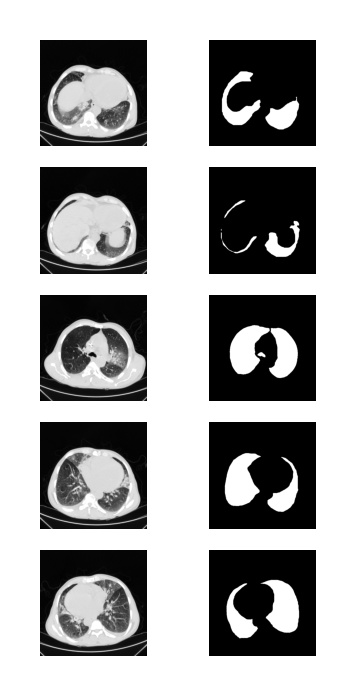

In [ ]:
# Preview Images
plt.figure(figsize=(1,2),dpi=400)
images,masks=train_img_ds.next(),train_mask_ds.next()
for i in range(5):
  plt.subplot(5,2,i*2+1)
  plt.imshow(images[i],cmap='gray')
  plt.axis('off')
  plt.subplot(5,2,i*2+2)
  plt.imshow(masks[i],cmap='gray')
  plt.axis('off')

## `+` Set Global Parameters

In [ ]:
# Hyperparameters
BATCH_SIZE  = 8
EPOCHS      = 50

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

## `i` Model Design

In [ ]:
def double_conv(input,n_filters):
  x=Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(input)
  x=Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)

  return x

In [ ]:
def downsample_block(input,n_filters):
  f=double_conv(input,n_filters)
  p=MaxPool2D()(f)
  p=Dropout(0.2)(p)

  return f, p

In [ ]:
def upsample_block(input,skip_connection_features,n_filters):
  x= Conv2DTranspose(n_filters, (3,3), 2, padding='same')(input)
  x=Concatenate()([x,skip_connection_features])
  x=Dropout(0.2)(x)
  x=double_conv(x,n_filters)

  return x

In [ ]:
inputs=Input((512,512,1))

#Encoder
f1, p1 = downsample_block(input=inputs,n_filters=32)
f2, p2 = downsample_block(input=p1,n_filters=64)
f3, p3 = downsample_block(input=p2,n_filters=128)
f4, p4 = downsample_block(input=p3,n_filters=256)

#Bottleneck
Bottleneck = double_conv(input=p4,n_filters=512)

#Decoder
u1 = upsample_block(input=Bottleneck,skip_connection_features=f4,n_filters=256)
u2 = upsample_block(input=u1,skip_connection_features=f3,n_filters=128)
u3 = upsample_block(input=u2,skip_connection_features=f2,n_filters=64)
u4 = upsample_block(input=u3,skip_connection_features=f1,n_filters=32)

#1x1 conv
outputs = Conv2D(1,(1,1),padding='same',activation='sigmoid')(u4)

model = keras.Model(inputs,outputs,name='U_NET')
model.summary()

Model: "U_NET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_209 (Conv2D)         (None, 512, 512, 32)         320       ['input_12[0][0]']            
                                                                                                  
 conv2d_210 (Conv2D)         (None, 512, 512, 32)         9248      ['conv2d_209[0][0]']          
                                                                                                  
 max_pooling2d_44 (MaxPooli  (None, 256, 256, 32)         0         ['conv2d_210[0][0]']          
 ng2D)                                                                                        

## `ii` Model Compilation & Training

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])

In [ ]:
train_segment_gen = zip(train_img_ds,train_mask_ds)
val_segment_gen = zip(val_image_ds,val_mask_ds)

In [ ]:
callback = model.fit(
    train_segment_gen,
    epochs=EPOCHS,
    steps_per_epoch=train_img_ds.samples // BATCH_SIZE,
    validation_data=val_segment_gen,
    validation_steps=val_image_ds.samples // BATCH_SIZE
)


Epoch 1/50
23/23 [==============================] - 25s 898ms/step - loss: 36672143360.0000 - accuracy: 0.8490 - val_loss: 0.2515 - val_accuracy: 0.9617
Epoch 2/50
23/23 [==============================] - 20s 882ms/step - loss: 0.3665 - accuracy: 0.8794 - val_loss: 0.1692 - val_accuracy: 0.9605
Epoch 3/50
23/23 [==============================] - 19s 847ms/step - loss: 0.3420 - accuracy: 0.8791 - val_loss: 0.1621 - val_accuracy: 0.9617
Epoch 4/50
23/23 [==============================] - 20s 867ms/step - loss: 0.3102 - accuracy: 0.8788 - val_loss: 0.2831 - val_accuracy: 0.9534
Epoch 5/50
23/23 [==============================] - 20s 851ms/step - loss: 0.2944 - accuracy: 0.8800 - val_loss: 0.1988 - val_accuracy: 0.9617
Epoch 6/50
23/23 [==============================] - 20s 875ms/step - loss: 0.2831 - accuracy: 0.8787 - val_loss: 0.2336 - val_accuracy: 0.9565
Epoch 7/50
23/23 [==============================] - 20s 871ms/step - loss: 0.2684 - accuracy: 0.8813 - val_loss: 0.1528 - val_accura

## `iii` Model Evaluation

In [ ]:
train_evaluation = model.evaluate(train_segment_gen)
print("Train Evaluation Loss: {:.2f}%".format(train_evaluation[0]*100))
print("Train Evaluation Accuracy: {:.2f}%".format(train_evaluation[1]*100))

  67965/Unknown - 13182s 194ms/step - loss: 0.0561 - accuracy: 0.9830

In [ ]:
val_evaluation = model.evaluate(val_segment_gen)
print("Validation Evaluation Loss: {:.2f}%".format(val_evaluation[0]*100))
print("Validation Evaluation Accuracy: {:.2f}%".format(val_evaluation[1]*100))

    383/Unknown - 76s 197ms/step - loss: 0.1251 - accuracy: 0.9629

## `iv` Result Visualization

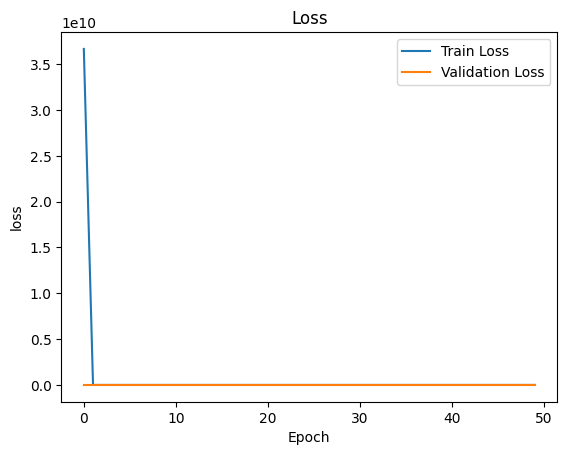

In [ ]:
plt.plot(callback.history['loss'], label='Train Loss')
plt.plot(callback.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

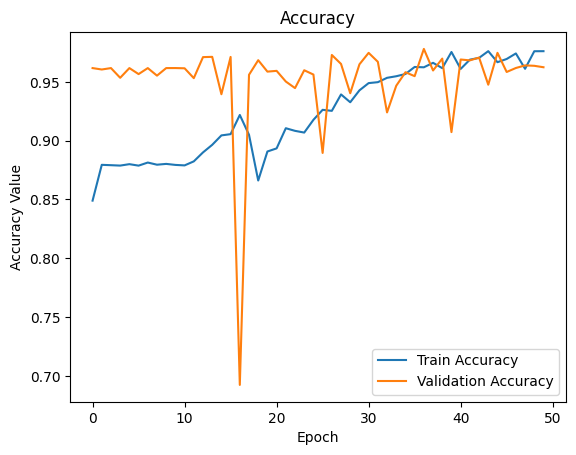

In [ ]:
plt.plot(callback.history['accuracy'],label='Train Accuracy')
plt.plot(callback.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
num_samples = 5
validation_samples = next(val_segment_gen)
input_images = validation_samples[0][:num_samples]
true_masks = validation_samples[1][:num_samples]

predicted_masks = model.predict(input_images)


1/1 [==============================] - 7s 7s/step


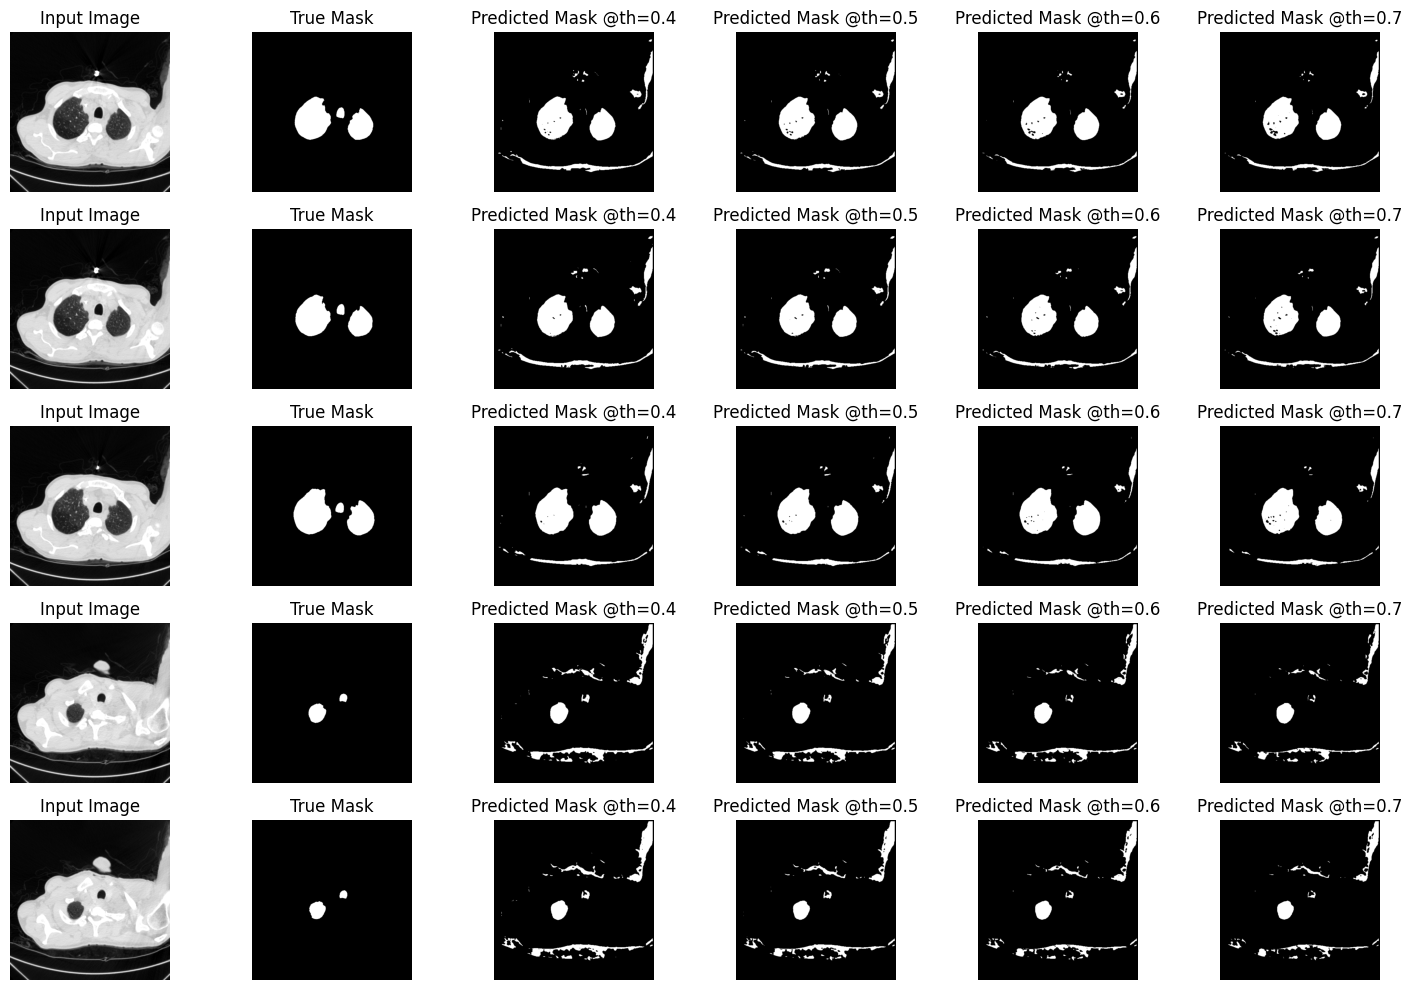

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(num_samples, 6, 6*i+1)
    plt.imshow(input_images[i], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(num_samples, 6, 6*i+2)
    plt.imshow(true_masks[i], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(num_samples, 6, 6*i+3)
    plt.imshow(predicted_masks[i] > 0.4, cmap='gray')
    plt.title('Predicted Mask @th=0.4')
    plt.axis('off')

    plt.subplot(num_samples, 6, 6*i+4)
    plt.imshow(predicted_masks[i] > 0.5, cmap='gray')
    plt.title('Predicted Mask @th=0.5')
    plt.axis('off')

    plt.subplot(num_samples, 6, 6*i+5)
    plt.imshow(predicted_masks[i] > 0.6, cmap='gray')
    plt.title('Predicted Mask @th=0.6')
    plt.axis('off')

    plt.subplot(num_samples, 6, 6*i+6)
    plt.imshow(predicted_masks[i] > 0.7, cmap='gray')
    plt.title('Predicted Mask @th=0.7')
    plt.axis('off')

plt.tight_layout()
plt.show()


**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   119M      0  0:00:06  0:00:06 --:--:--  109M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [ ]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
# Training/Validation Generator/Dataset
train_ds, val_ds = image_dataset_from_directory(
    directory='PetImages',
    seed=SEED,batch_size=32,
    image_size=(180,180),
    validation_split=0.15,
    subset='both',
    label_mode='binary'
)

Found 23410 files belonging to 2 classes.
Using 19899 files for training.
Using 3511 files for validation.


### Preview the Images

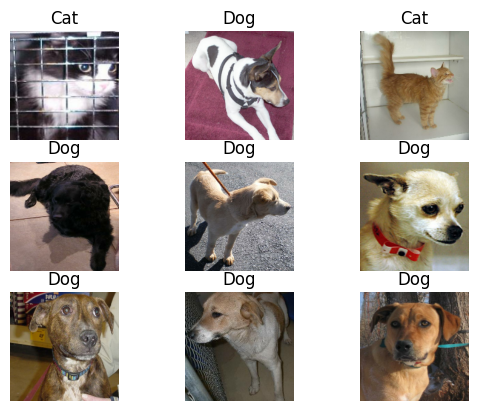

In [ ]:
for images, labels in train_ds.take(1):
    num_images = min(len(images), 9)
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(['Cat', 'Dog'][labels[i]])
        plt.axis('off')
plt.show()


## `+` Set Global Parameters

In [ ]:
# Hyperparameters
BATCH_SIZE  = 46
EPOCHS      = 35

## `i` Model Design

In [ ]:
inputs = Input(shape=(180, 180, 3))

pre_trained = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

for layer in pre_trained.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(pre_trained.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model2 = keras.Model(inputs, output)

94765736/94765736 [==============================] - 1s 0us/step


## `ii` Model Compilation & Training

In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'], loss='binary_crossentropy')

In [ ]:
steps_per_epoch = train_ds.cardinality().numpy() // BATCH_SIZE

validation_steps = val_ds.cardinality().numpy() // BATCH_SIZE

callback_2 = model2.fit(train_ds, epochs=EPOCHS,
                        validation_data=val_ds,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps
                        )

Epoch 1/35
13/13 [==============================] - 12s 187ms/step - loss: 2.0227 - accuracy: 0.8438 - val_loss: 0.3307 - val_accuracy: 0.9531
Epoch 2/35
13/13 [==============================] - 1s 93ms/step - loss: 0.6161 - accuracy: 0.9519 - val_loss: 0.0299 - val_accuracy: 0.9844
Epoch 3/35
13/13 [==============================] - 1s 93ms/step - loss: 0.6115 - accuracy: 0.9351 - val_loss: 0.5207 - val_accuracy: 0.9219
Epoch 4/35
13/13 [==============================] - 1s 88ms/step - loss: 0.3267 - accuracy: 0.9519 - val_loss: 0.2921 - val_accuracy: 0.9375
Epoch 5/35
13/13 [==============================] - 1s 108ms/step - loss: 0.3160 - accuracy: 0.9543 - val_loss: 0.0785 - val_accuracy: 0.9844
Epoch 6/35
13/13 [==============================] - 1s 90ms/step - loss: 0.1795 - accuracy: 0.9543 - val_loss: 0.0496 - val_accuracy: 0.9844
Epoch 7/35
13/13 [==============================] - 1s 81ms/step - loss: 0.1185 - accuracy: 0.9591 - val_loss: 0.1267 - val_accuracy: 0.9531
Epoch 8/35

## `iii` Model Evaluation

In [ ]:
train_evaluation = model2.evaluate(train_ds)
print("Train Evaluation Loss: {:.2f}%".format(train_evaluation[0]*100))
print("Train Evaluation Accuracy: {:.2f}%".format(train_evaluation[1]*100))

622/622 [==============================] - 46s 74ms/step - loss: 0.0745 - accuracy: 0.9707
Train Evaluation Loss: 7.45%
Train Evaluation Accuracy: 97.07%


In [ ]:
val_evaluation = model2.evaluate(val_ds)
print("Validation Evaluation Loss: {:.2f}%".format(val_evaluation[0]*100))
print("Validation Evaluation Accuracy: {:.2f}%".format(val_evaluation[1]*100))

110/110 [==============================] - 10s 88ms/step - loss: 0.0834 - accuracy: 0.9692
Validation Evaluation Loss: 8.34%
Validation Evaluation Accuracy: 96.92%


## `iv` Result Visualization

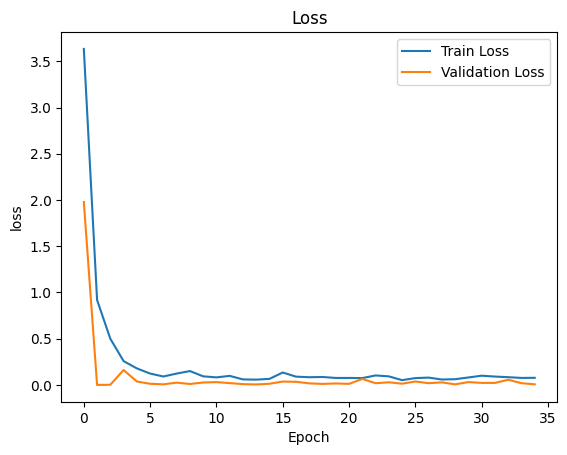

In [ ]:
plt.plot(callback_2.history['loss'], label='Train Loss')
plt.plot(callback_2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

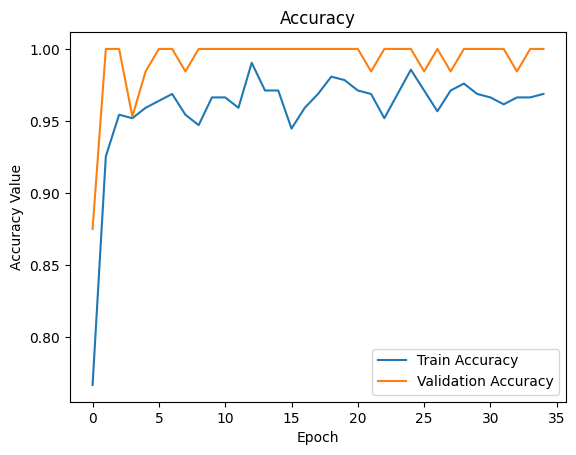

In [ ]:
plt.plot(callback_2.history['accuracy'],label='Train Accuracy')
plt.plot(callback_2.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

In [ ]:
num_samples = 5
validation_samples = val_ds.take(1)

val_images = []
val_labels = []

for image, label in validation_samples:
    val_images.append(image)
    val_labels.append(label)

val_images = val_images[:num_samples]
val_labels = val_labels[:num_samples]

predicted_labels = model2.predict(val_images)


1/1 [==============================] - 1s 978ms/step


In [ ]:
predicted_labels.min(),predicted_labels.max()

(4.8580434e-10, 0.99999726)

1/1 [==============================] - 0s 44ms/step


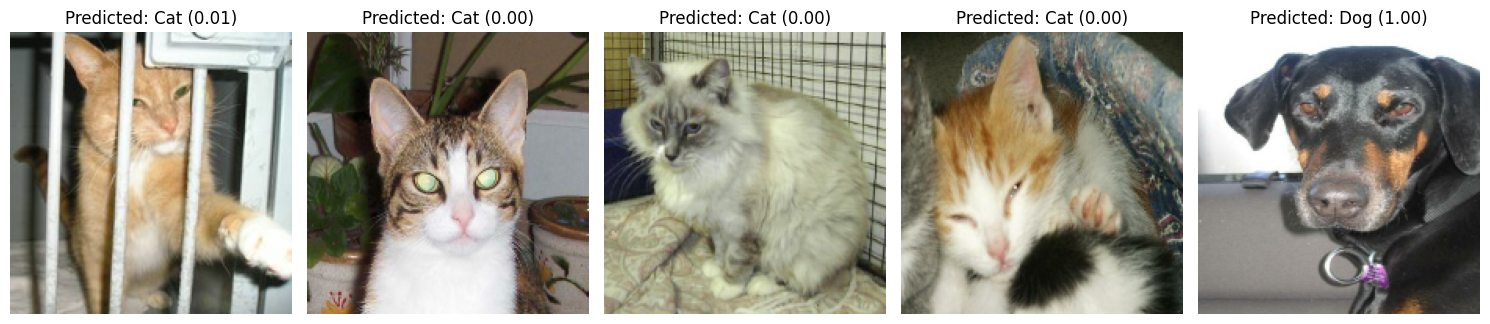

In [ ]:
# Number of images you want to predict the class for
num_images = 5

# Load data from the validation dataset
validation_samples = list(val_ds.take(1))
val_images, val_labels = validation_samples[0]

# Loop through the images and predict their classes
plt.figure(figsize=(15, 10))
for i in range(num_images):
    # Preprocess the data for prediction
    image_array = np.expand_dims(val_images[i] , axis=0)
    predicted_prob = model2.predict(image_array)[0][0]
    predicted_label = "Dog" if predicted_prob > 0.5 else "Cat"  # Use threshold 0.5 or any other threshold you prefer

    # Display the image along with the predicted label
    plt.subplot(1, num_images, i+1)
    plt.imshow(val_images[i] )
    plt.title(f'Predicted: {predicted_label} ({predicted_prob:.2f})')
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 920ms/step


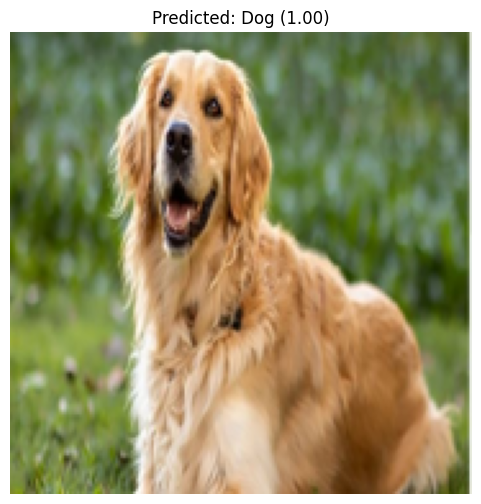

In [ ]:
from PIL import Image
# Load an image from your desktop
image_path = "Dog3.JPG"
image = Image.open(image_path)
image = image.resize((180, 180))  # Resize the image to match the model input size

# If the image has an alpha channel, remove it
if image.mode == 'RGBA':
    image = image.convert('RGB')

image_array = np.array(image)
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Classify the image
predicted_class = model2.predict(image_array)[0][0]
predicted_label = "Dog" if predicted_class > 0.5 else "Cat"

# Plot the input image along with the predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f'Predicted: {predicted_label} ({predicted_class:.2f})')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 27ms/step


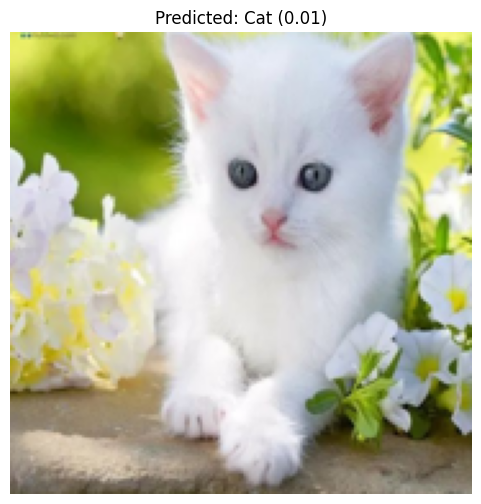

In [ ]:
# Load an image from your desktop
image_path = "Cat.jpg"
image = Image.open(image_path)
image = image.resize((180, 180))  # Resize the image to match the model input size

# If the image has an alpha channel, remove it
if image.mode == 'RGBA':
    image = image.convert('RGB')

image_array = np.array(image)
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Classify the image
predicted_class = model2.predict(image_array)[0][0]
predicted_label = "Dog" if predicted_class > 0.5 else "Cat"

# Plot the input image along with the predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f'Predicted: {predicted_label} ({predicted_class:.2f})')
plt.axis('off')
plt.show()


----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$